In [0]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib
import torch 
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
from torch.distributions import Normal, MultivariateNormal, Uniform
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time

In [0]:
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]
def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot([[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

In [33]:
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


torch.Size([100000, 2])


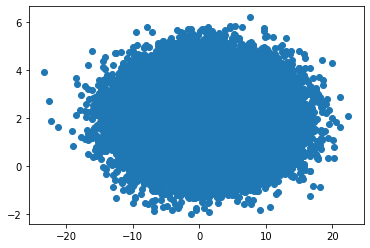

In [34]:
X1 = torch.from_numpy(sample_data_1()).float()
print(X1.shape)
plt.scatter(X1[:, 0], X1[:, 1])

torch.Size([100000, 2])


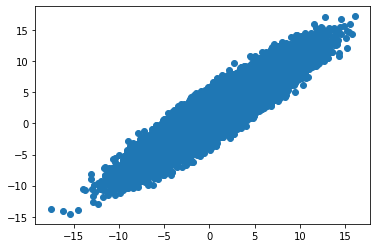

In [35]:
X2 = torch.from_numpy(sample_data_2()).float()
print(X2.shape)
plt.scatter(X2[:, 0], X2[:, 1])

In [0]:
class Configuration1(nn.Module):
    def __init__(self):
        super(Configuration1, self).__init__()
        self.layers = nn.Sequential(
          nn.Linear(2, 256),
          nn.ReLU(),
          nn.Linear(256, 128),
          nn.ReLU()
        )
        self.mu = nn.Linear(128, 2)
        self.var = nn.Linear(128, 2)
            
    def forward(self, x):
        layers = self.layers(x)
        return self.mu(layers), torch.exp(self.var(layers))

In [0]:
class Configuration2(nn.Module):
    def __init__(self, n_layers=3, n_features=128):
        super(Configuration2, self).__init__()
        self.layers = nn.Sequential(
          nn.Linear(2, 256),
          nn.ReLU(),
          nn.Linear(256, 128),
          nn.ReLU()
        )
        self.mu = nn.Linear(128, 2)
        self.var = nn.Linear(128, 1)
            
    def forward(self, x):
        layers = self.layers(x)
        var = self.var(layers) * torch.ones([1, 2]).to(DEVICE)
        var = torch.exp(var)
        return self.mu(layers), var

In [0]:
class VAE(nn.Module):
    def __init__(self, config):
        super(VAE, self).__init__()
        self.encoder = Configuration1()
        self.decoder = config
        self.distrib = MultivariateNormal(torch.zeros(2), torch.diag_embed(torch.ones(2)))
    
    def forward(self, x):
        mu_z, var_z = self.encoder(x)
        z = self.sample_normal(mu_z, var_z)
        mu_x, var_x = self.decoder(z)
        return mu_z, var_z, z, mu_x, var_x
      
    def loss(self, x):
        mu_z, var_z, z, mu_x, var_x = self.forward(x)
        nll = torch.sum(-0.5 * (torch.log(np.pi * 2 * var_x) + torch.pow(x - mu_x, 2) / var_x), dim=1, keepdim=True)
        nll = -torch.sum(nll, dim=1, keepdim=True)
        kl = 1.0 + torch.log(var_z) - torch.pow(mu_z, 2) - var_z
        kl = -0.5 * torch.sum(kl, dim=1, keepdim=True)
        return nll, kl

    def sample(self, n):
        z = self.distrib.rsample((n,)).to(DEVICE)
        mu_x, var_x = self.decoder(z)
        x = self.sample_normal(mu_x, var_x)
        return x, mu_x, var_x

    def sample_normal(self, mu, var):
      return mu + torch.randn(mu.shape).cuda() * torch.sqrt(var)

In [0]:
def train(vae, data):
    optimizer = torch.optim.Adam(vae.parameters(), lr=2e-3)
    dataloader = DataLoader(data, batch_size=256, shuffle=True)

    nll_values = []
    kl_values = []
    vlb_values = []

    for i in trange(7):
        for batch in dataloader:
            batch = batch.to(DEVICE)
            nll, kl = vae.loss(batch)
            loss = torch.mean(nll + kl)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            nll_values.append(torch.mean(nll).detach().item() / 2.0 / np.log(2))
            kl_values.append(torch.mean(kl).detach().item())
            vlb_values.append(torch.mean(-loss).detach().item())
    return nll_values, kl_values, vlb_values

In [43]:
model11 = VAE(Configuration1()).to(DEVICE)
nll11, kl11, vlb11 = train(model11, X1)

In [0]:
def plot(values, label):
    plt.plot(values, label=label)
    plt.legend()
    plt.show()

In [0]:
def draw_samples(model, n):
    x, mu_x, var_x = model.sample(n)
    x = x.cpu().detach().numpy()
    mu_x = mu_x.cpu().detach().numpy()
    plt.scatter(x[:, 0], x[:, 1], marker='.', label="Samples From Full Generation Path")
    plt.scatter(mu_x[:, 0], mu_x[:, 1], marker='.', label="Without Decoder Noise")
    plt.legend()

In [0]:
def plot_all(nll, kl, vlb, vae):
  plot(nll, 'Decoder Term')
  plot(kl, 'KL Divergence')
  plot(vlb, 'Variational Lower Bound')
  draw_samples(vae, 100000)

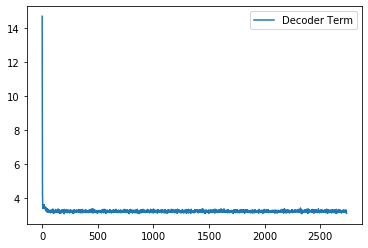

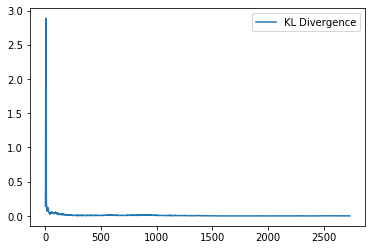

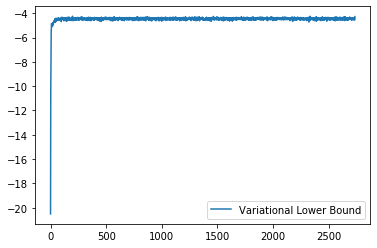

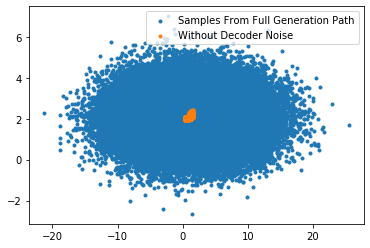

In [47]:
plot_all(nll11, kl11, vlb11, model11)

In [48]:
model21 = VAE(Configuration1()).to(DEVICE)
nll21, kl21, vlb21 = train(model21, X2)

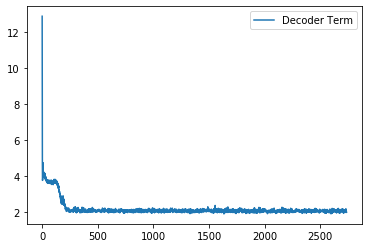

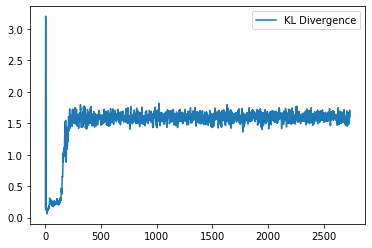

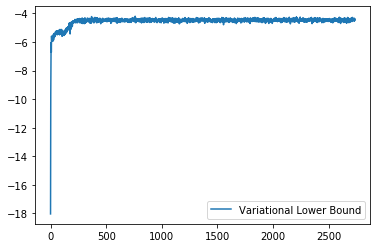

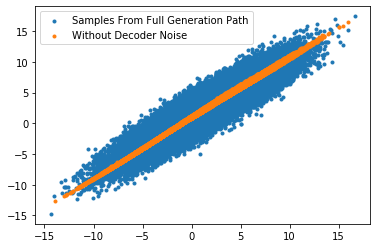

In [49]:
plot_all(nll21, kl21, vlb21, model21)

In [50]:
model12 = VAE(Configuration2()).to(DEVICE)
nll12, kl12, vlb12 = train(model12, X1)

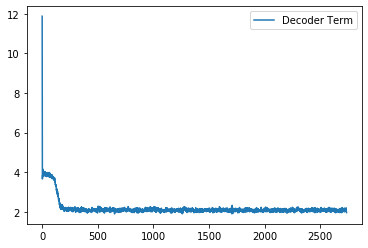

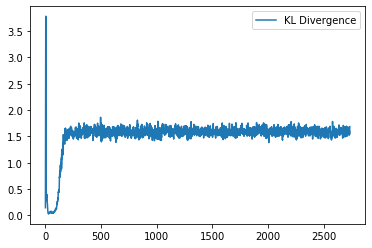

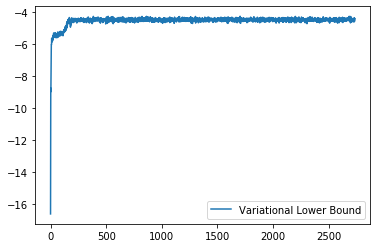

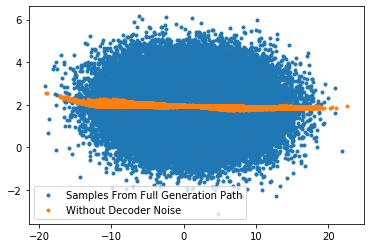

In [51]:
plot_all(nll12, kl12, vlb12, model12)

In [52]:
model22 = VAE(Configuration2()).to(DEVICE)
nll22, kl22, vlb22 = train(model22, X2)

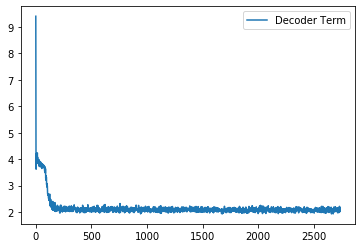

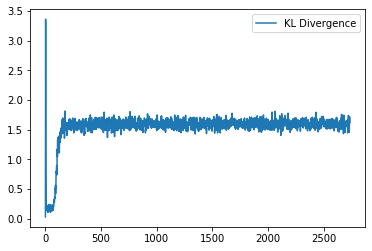

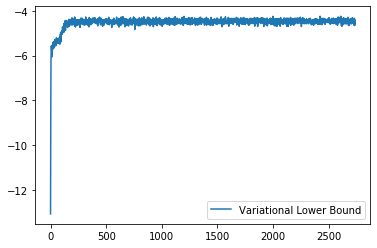

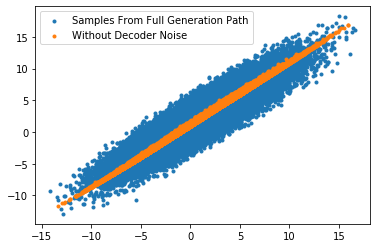

In [53]:
plot_all(nll22, kl22, vlb22, model22)